# **BirdCLEF 2025 Training Notebook**

This is a baseline training pipeline for BirdCLEF 2025 using EfficientNetB0 with PyTorch and Timm(for pretrained EffNet). You can check inference and preprocessing notebooks in the following links: 

- [EfficientNet B0 Pytorch [Inference] | BirdCLEF'25](https://www.kaggle.com/code/kadircandrisolu/efficientnet-b0-pytorch-inference-birdclef-25)

  
- [Transforming Audio-to-Mel Spec. | BirdCLEF'25](https://www.kaggle.com/code/kadircandrisolu/transforming-audio-to-mel-spec-birdclef-25)  

Note that by default this notebook is in Debug Mode, so it will only train the model with 2 epochs, but the [weight](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-effnetb0-starter-weight) I used in the inference notebook was obtained after 10 epochs of training.

**Features**
* Implement with Pytorch and Timm
* Flexible audio processing with both pre-computed and on-the-fly mel spectrograms
* Stratified 5-fold cross-validation with ensemble capability
* Mixup training for improved generalization
* Spectrogram augmentations (time/frequency masking, brightness adjustment)
* AdamW optimizer with Cosine Annealing LR scheduling
* Debug mode for quick experimentation with smaller datasets

**Pre-computed Spectrograms**
For faster training, you can use pre-computed mel spectrograms from [this dataset](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms) by setting `LOAD_DATA = True`

## Libraries

In [5]:
import os
import logging
import random
import gc
import time
import cv2
import math
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import timm

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.ERROR)

## Configuration

In [6]:
class CFG:
    
    seed = 42
    debug = True  
    apex = False
    print_freq = 100
    num_workers = 2
    
    OUTPUT_DIR = '/kaggle/working/'

    train_datadir = '/kaggle/input/birdclef-2025/train_audio'
    train_csv = '/kaggle/input/birdclef-2025/train.csv'
    test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
    submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
    taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'

    spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
 
    model_name = 'resnet18'  
    pretrained = True
    in_channels = 1

    LOAD_DATA = True  
    FS = 32000
    TARGET_DURATION = 5.0
    TARGET_SHAPE = (256, 256)
    
    N_FFT = 1024
    HOP_LENGTH = 512
    N_MELS = 128
    FMIN = 50
    FMAX = 14000
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    epochs = 10  
    batch_size = 32  
    criterion = 'BCEWithLogitsLoss'

    n_fold = 5
    selected_folds = [0, 1, 2, 3, 4]   

    optimizer = 'AdamW'
    lr = 5e-4 
    weight_decay = 1e-5
  
    scheduler = 'CosineAnnealingLR'
    min_lr = 1e-6
    T_max = epochs

    aug_prob = 0.5  
    mixup_alpha = 0.5  
    
    def update_debug_settings(self):
        if self.debug:
            self.epochs = 100
            self.selected_folds = [0, 1, 2]

cfg = CFG()

## Utilities

In [7]:
def set_seed(seed=42):
    """
    Set seed for reproducibility
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)

## Pre-processing
These functions handle the transformation of audio files to mel spectrograms for model input, with flexibility controlled by the `LOAD_DATA` parameter. The process involves either loading pre-computed spectrograms from this [dataset](https://www.kaggle.com/datasets/kadircandrisolu/birdclef25-mel-spectrograms) (when `LOAD_DATA=True`) or dynamically generating them (when `LOAD_DATA=False`), transforming audio data into spectrogram representations, and preparing it for the neural network.

In [8]:
def audio2melspec(audio_data, cfg):
    """Convert audio data to mel spectrogram"""
    if np.isnan(audio_data).any():
        mean_signal = np.nanmean(audio_data)
        audio_data = np.nan_to_num(audio_data, nan=mean_signal)

    mel_spec = librosa.feature.melspectrogram(
        y=audio_data,
        sr=cfg.FS,
        n_fft=cfg.N_FFT,
        hop_length=cfg.HOP_LENGTH,
        n_mels=cfg.N_MELS,
        fmin=cfg.FMIN,
        fmax=cfg.FMAX,
        power=2.0
    )

    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    mel_spec_norm = (mel_spec_db - mel_spec_db.min()) / (mel_spec_db.max() - mel_spec_db.min() + 1e-8)
    
    return mel_spec_norm

def process_audio_file(audio_path, cfg):
    """Process a single audio file to get the mel spectrogram"""
    try:
        audio_data, _ = librosa.load(audio_path, sr=cfg.FS)

        target_samples = int(cfg.TARGET_DURATION * cfg.FS)

        if len(audio_data) < target_samples:
            n_copy = math.ceil(target_samples / len(audio_data))
            if n_copy > 1:
                audio_data = np.concatenate([audio_data] * n_copy)

        # Extract center 5 seconds
        start_idx = max(0, int(len(audio_data) / 2 - target_samples / 2))
        end_idx = min(len(audio_data), start_idx + target_samples)
        center_audio = audio_data[start_idx:end_idx]

        if len(center_audio) < target_samples:
            center_audio = np.pad(center_audio, 
                                 (0, target_samples - len(center_audio)), 
                                 mode='constant')

        mel_spec = audio2melspec(center_audio, cfg)
        
        if mel_spec.shape != cfg.TARGET_SHAPE:
            mel_spec = cv2.resize(mel_spec, cfg.TARGET_SHAPE, interpolation=cv2.INTER_LINEAR)

        return mel_spec.astype(np.float32)
        
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

def generate_spectrograms(df, cfg):
    """Generate spectrograms from audio files"""
    print("Generating mel spectrograms from audio files...")
    start_time = time.time()

    all_bird_data = {}
    errors = []

    for i, row in tqdm(df.iterrows(), total=len(df)):
        if cfg.debug and i >= 1000:
            break
        
        try:
            samplename = row['samplename']
            filepath = row['filepath']
            
            mel_spec = process_audio_file(filepath, cfg)
            
            if mel_spec is not None:
                all_bird_data[samplename] = mel_spec
            
        except Exception as e:
            print(f"Error processing {row.filepath}: {e}")
            errors.append((row.filepath, str(e)))

    end_time = time.time()
    print(f"Processing completed in {end_time - start_time:.2f} seconds")
    print(f"Successfully processed {len(all_bird_data)} files out of {len(df)}")
    print(f"Failed to process {len(errors)} files")
    
    return all_bird_data

## Dataset Preparation and Data Augmentations
We'll convert audio to mel spectrograms and apply random augmentations with 50% probability each - including time stretching, pitch shifting, and volume adjustments. This randomized approach creates diverse training samples from the same audio files

In [9]:
class BirdCLEFDatasetFromNPY(Dataset):
    def __init__(self, df, cfg, spectrograms=None, mode="train"):
        self.df = df
        self.cfg = cfg
        self.mode = mode

        self.spectrograms = spectrograms
        
        taxonomy_df = pd.read_csv(self.cfg.taxonomy_csv)
        self.species_ids = taxonomy_df['primary_label'].tolist()
        self.num_classes = len(self.species_ids)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.species_ids)}

        if 'filepath' not in self.df.columns:
            self.df['filepath'] = self.cfg.train_datadir + '/' + self.df.filename
        
        if 'samplename' not in self.df.columns:
            self.df['samplename'] = self.df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])

        sample_names = set(self.df['samplename'])
        if self.spectrograms:
            found_samples = sum(1 for name in sample_names if name in self.spectrograms)
            print(f"Found {found_samples} matching spectrograms for {mode} dataset out of {len(self.df)} samples")
        
        if cfg.debug:
            self.df = self.df.sample(min(1000, len(self.df)), random_state=cfg.seed).reset_index(drop=True)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        samplename = row['samplename']
        spec = None

        if self.spectrograms and samplename in self.spectrograms:
            spec = self.spectrograms[samplename]
        elif not self.cfg.LOAD_DATA:
            spec = process_audio_file(row['filepath'], self.cfg)

        if spec is None:
            spec = np.zeros(self.cfg.TARGET_SHAPE, dtype=np.float32)
            if self.mode == "train":  # Only print warning during training
                print(f"Warning: Spectrogram for {samplename} not found and could not be generated")

        spec = torch.tensor(spec, dtype=torch.float32).unsqueeze(0)  # Add channel dimension

        if self.mode == "train" and random.random() < self.cfg.aug_prob:
            spec = self.apply_spec_augmentations(spec)
        
        target = self.encode_label(row['primary_label'])
        
        if 'secondary_labels' in row and row['secondary_labels'] not in [[''], None, np.nan]:
            if isinstance(row['secondary_labels'], str):
                secondary_labels = eval(row['secondary_labels'])
            else:
                secondary_labels = row['secondary_labels']
            
            for label in secondary_labels:
                if label in self.label_to_idx:
                    target[self.label_to_idx[label]] = 1.0
        
        return {
            'melspec': spec, 
            'target': torch.tensor(target, dtype=torch.float32),
            'filename': row['filename']
        }
    
    def apply_spec_augmentations(self, spec):
        """Apply augmentations to spectrogram"""
    
        # Time masking (horizontal stripes)
        if random.random() < 0.5:
            num_masks = random.randint(1, 3)
            for _ in range(num_masks):
                width = random.randint(5, 20)
                start = random.randint(0, spec.shape[2] - width)
                spec[0, :, start:start+width] = 0
        
        # Frequency masking (vertical stripes)
        if random.random() < 0.5:
            num_masks = random.randint(1, 3)
            for _ in range(num_masks):
                height = random.randint(5, 20)
                start = random.randint(0, spec.shape[1] - height)
                spec[0, start:start+height, :] = 0
        
        # Random brightness/contrast
        if random.random() < 0.5:
            gain = random.uniform(0.8, 1.2)
            bias = random.uniform(-0.1, 0.1)
            spec = spec * gain + bias
            spec = torch.clamp(spec, 0, 1) 
            
        return spec
    
    def encode_label(self, label):
        """Encode label to one-hot vector"""
        target = np.zeros(self.num_classes)
        if label in self.label_to_idx:
            target[self.label_to_idx[label]] = 1.0
        return target

In [10]:
def collate_fn(batch):
    """Custom collate function to handle different sized spectrograms"""
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return {}
        
    result = {key: [] for key in batch[0].keys()}
    
    for item in batch:
        for key, value in item.items():
            result[key].append(value)
    
    for key in result:
        if key == 'target' and isinstance(result[key][0], torch.Tensor):
            result[key] = torch.stack(result[key])
        elif key == 'melspec' and isinstance(result[key][0], torch.Tensor):
            shapes = [t.shape for t in result[key]]
            if len(set(str(s) for s in shapes)) == 1:
                result[key] = torch.stack(result[key])
    
    return result

## Model Definition

In [12]:
class BirdCLEFModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        
        taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
        cfg.num_classes = len(taxonomy_df)
        
        self.backbone = timm.create_model(
            cfg.model_name,
            pretrained=cfg.pretrained,
            in_chans=cfg.in_channels,
            drop_rate=0.2,
            drop_path_rate=0.2
        )
        
        if 'efficientnet' in cfg.model_name:
            backbone_out = self.backbone.classifier.in_features
            self.backbone.classifier = nn.Identity()
        elif 'resnet' in cfg.model_name:
            backbone_out = self.backbone.fc.in_features
            self.backbone.fc = nn.Identity()
        else:
            backbone_out = self.backbone.get_classifier().in_features
            self.backbone.reset_classifier(0, '')
        
        self.pooling = nn.AdaptiveAvgPool2d(1)
            
        self.feat_dim = backbone_out
        
        self.classifier = nn.Linear(backbone_out, cfg.num_classes)
        
        self.mixup_enabled = hasattr(cfg, 'mixup_alpha') and cfg.mixup_alpha > 0
        if self.mixup_enabled:
            self.mixup_alpha = cfg.mixup_alpha
            
    def forward(self, x, targets=None):
    
        if self.training and self.mixup_enabled and targets is not None:
            mixed_x, targets_a, targets_b, lam = self.mixup_data(x, targets)
            x = mixed_x
        else:
            targets_a, targets_b, lam = None, None, None
        
        features = self.backbone(x)
        
        if isinstance(features, dict):
            features = features['features']
            
        if len(features.shape) == 4:
            features = self.pooling(features)
            features = features.view(features.size(0), -1)
        
        logits = self.classifier(features)
        
        if self.training and self.mixup_enabled and targets is not None:
            loss = self.mixup_criterion(F.binary_cross_entropy_with_logits, 
                                       logits, targets_a, targets_b, lam)
            return logits, loss
            
        return logits
    
    def mixup_data(self, x, targets):
        """Applies mixup to the data batch"""
        batch_size = x.size(0)

        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)

        indices = torch.randperm(batch_size).to(x.device)

        mixed_x = lam * x + (1 - lam) * x[indices]
        
        return mixed_x, targets, targets[indices], lam
    
    def mixup_criterion(self, criterion, pred, y_a, y_b, lam):
        """Applies mixup to the loss function"""
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Training Utilities
We are configuring our optimization strategy with the AdamW optimizer, cosine scheduling, and the BCEWithLogitsLoss criterion.

In [13]:
def get_optimizer(model, cfg):
  
    if cfg.optimizer == 'Adam':
        optimizer = optim.Adam(
            model.parameters(),
            lr=cfg.lr,
            weight_decay=cfg.weight_decay
        )
    elif cfg.optimizer == 'AdamW':
        optimizer = optim.AdamW(
            model.parameters(),
            lr=cfg.lr,
            weight_decay=cfg.weight_decay
        )
    elif cfg.optimizer == 'SGD':
        optimizer = optim.SGD(
            model.parameters(),
            lr=cfg.lr,
            momentum=0.9,
            weight_decay=cfg.weight_decay
        )
    else:
        raise NotImplementedError(f"Optimizer {cfg.optimizer} not implemented")
        
    return optimizer

def get_scheduler(optimizer, cfg):
   
    if cfg.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=cfg.T_max,
            eta_min=cfg.min_lr
        )
    elif cfg.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            min_lr=cfg.min_lr,
            verbose=True
        )
    elif cfg.scheduler == 'StepLR':
        scheduler = lr_scheduler.StepLR(
            optimizer,
            step_size=cfg.epochs // 3,
            gamma=0.5
        )
    elif cfg.scheduler == 'OneCycleLR':
        scheduler = None  
    else:
        scheduler = None
        
    return scheduler

def get_criterion(cfg):
 
    if cfg.criterion == 'BCEWithLogitsLoss':
        criterion = nn.BCEWithLogitsLoss()
    else:
        raise NotImplementedError(f"Criterion {cfg.criterion} not implemented")
        
    return criterion

## Training Loop

In [14]:
def train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None):
    
    model.train()
    losses = []
    all_targets = []
    all_outputs = []
    
    pbar = tqdm(enumerate(loader), total=len(loader), desc="Training")
    
    for step, batch in pbar:
    
        if isinstance(batch['melspec'], list):
            batch_outputs = []
            batch_losses = []
            
            for i in range(len(batch['melspec'])):
                inputs = batch['melspec'][i].unsqueeze(0).to(device)
                target = batch['target'][i].unsqueeze(0).to(device)
                
                optimizer.zero_grad()
                output = model(inputs)
                loss = criterion(output, target)
                loss.backward()
                
                batch_outputs.append(output.detach().cpu())
                batch_losses.append(loss.item())
            
            optimizer.step()
            outputs = torch.cat(batch_outputs, dim=0).numpy()
            loss = np.mean(batch_losses)
            targets = batch['target'].numpy()
            
        else:
            inputs = batch['melspec'].to(device)
            targets = batch['target'].to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            
            if isinstance(outputs, tuple):
                outputs, loss = outputs  
            else:
                loss = criterion(outputs, targets)
                
            loss.backward()
            optimizer.step()
            
            outputs = outputs.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()
        
        if scheduler is not None and isinstance(scheduler, lr_scheduler.OneCycleLR):
            scheduler.step()
            
        all_outputs.append(outputs)
        all_targets.append(targets)
        losses.append(loss if isinstance(loss, float) else loss.item())
        
        pbar.set_postfix({
            'train_loss': np.mean(losses[-10:]) if losses else 0,
            'lr': optimizer.param_groups[0]['lr']
        })
    
    all_outputs = np.concatenate(all_outputs)
    all_targets = np.concatenate(all_targets)
    auc = calculate_auc(all_targets, all_outputs)
    avg_loss = np.mean(losses)
    
    return avg_loss, auc

def validate(model, loader, criterion, device):
   
    model.eval()
    losses = []
    all_targets = []
    all_outputs = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation"):
            if isinstance(batch['melspec'], list):
                batch_outputs = []
                batch_losses = []
                
                for i in range(len(batch['melspec'])):
                    inputs = batch['melspec'][i].unsqueeze(0).to(device)
                    target = batch['target'][i].unsqueeze(0).to(device)
                    
                    output = model(inputs)
                    loss = criterion(output, target)
                    
                    batch_outputs.append(output.detach().cpu())
                    batch_losses.append(loss.item())
                
                outputs = torch.cat(batch_outputs, dim=0).numpy()
                loss = np.mean(batch_losses)
                targets = batch['target'].numpy()
                
            else:
                inputs = batch['melspec'].to(device)
                targets = batch['target'].to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                outputs = outputs.detach().cpu().numpy()
                targets = targets.detach().cpu().numpy()
            
            all_outputs.append(outputs)
            all_targets.append(targets)
            losses.append(loss if isinstance(loss, float) else loss.item())
    
    all_outputs = np.concatenate(all_outputs)
    all_targets = np.concatenate(all_targets)
    
    auc = calculate_auc(all_targets, all_outputs)
    avg_loss = np.mean(losses)
    
    return avg_loss, auc

def calculate_auc(targets, outputs):
  
    num_classes = targets.shape[1]
    aucs = []
    
    probs = 1 / (1 + np.exp(-outputs))
    
    for i in range(num_classes):
        
        if np.sum(targets[:, i]) > 0:
            class_auc = roc_auc_score(targets[:, i], probs[:, i])
            aucs.append(class_auc)
    
    return np.mean(aucs) if aucs else 0.0

## Fold_auc

In [15]:
all_folds_auc = {}

## Training!

In [16]:
def run_training(df, cfg):
    """Training function that can either use pre-computed spectrograms or generate them on-the-fly"""

    taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
    species_ids = taxonomy_df['primary_label'].tolist()
    cfg.num_classes = len(species_ids)
    
    if cfg.debug:
        cfg.update_debug_settings()

    spectrograms = None
    if cfg.LOAD_DATA:
        print("Loading pre-computed mel spectrograms from NPY file...")
        try:
            spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
            print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms")
        except Exception as e:
            print(f"Error loading pre-computed spectrograms: {e}")
            print("Will generate spectrograms on-the-fly instead.")
            cfg.LOAD_DATA = False
    
    if not cfg.LOAD_DATA:
        print("Will generate spectrograms on-the-fly during training.")
        if 'filepath' not in df.columns:
            df['filepath'] = cfg.train_datadir + '/' + df.filename
        if 'samplename' not in df.columns:
            df['samplename'] = df.filename.map(lambda x: x.split('/')[0] + '-' + x.split('/')[-1].split('.')[0])
        
    skf = StratifiedKFold(n_splits=cfg.n_fold, shuffle=True, random_state=cfg.seed)
    
    best_scores = []
    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['primary_label'])):
        if fold not in cfg.selected_folds:
            continue
        fold_auc_history = []
        print(f'\n{"="*30} Fold {fold} {"="*30}')
        
        train_df = df.iloc[train_idx].reset_index(drop=True)
        val_df = df.iloc[val_idx].reset_index(drop=True)
        
        print(f'Training set: {len(train_df)} samples')
        print(f'Validation set: {len(val_df)} samples')
        
        train_dataset = BirdCLEFDatasetFromNPY(train_df, cfg, spectrograms=spectrograms, mode='train')
        val_dataset = BirdCLEFDatasetFromNPY(val_df, cfg, spectrograms=spectrograms, mode='valid')
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=cfg.batch_size, 
            shuffle=True, 
            num_workers=cfg.num_workers,
            pin_memory=True,
            collate_fn=collate_fn,
            drop_last=True
        )
        
        val_loader = DataLoader(
            val_dataset, 
            batch_size=cfg.batch_size, 
            shuffle=False, 
            num_workers=cfg.num_workers,
            pin_memory=True,
            collate_fn=collate_fn
        )
        
        model = BirdCLEFModel(cfg).to(cfg.device)
        optimizer = get_optimizer(model, cfg)
        criterion = get_criterion(cfg)
        
        if cfg.scheduler == 'OneCycleLR':
            scheduler = lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=cfg.lr,
                steps_per_epoch=len(train_loader),
                epochs=cfg.epochs,
                pct_start=0.1
            )
        else:
            scheduler = get_scheduler(optimizer, cfg)
        
        best_auc = 0
        best_epoch = 0
        
        for epoch in range(cfg.epochs):
            print(f"\nEpoch {epoch+1}/{cfg.epochs}")
            
            train_loss, train_auc = train_one_epoch(
                model, 
                train_loader, 
                optimizer, 
                criterion, 
                cfg.device,
                scheduler if isinstance(scheduler, lr_scheduler.OneCycleLR) else None
            )
            
            val_loss, val_auc = validate(model, val_loader, criterion, cfg.device)
            fold_auc_history.append(val_auc)
            if scheduler is not None and not isinstance(scheduler, lr_scheduler.OneCycleLR):
                if isinstance(scheduler, lr_scheduler.ReduceLROnPlateau):
                    scheduler.step(val_loss)
                else:
                    scheduler.step()

            print(f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
            
            if val_auc > best_auc:
                best_auc = val_auc
                best_epoch = epoch + 1
                print(f"New best AUC: {best_auc:.4f} at epoch {best_epoch}")

                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                    'epoch': epoch,
                    'val_auc': val_auc,
                    'train_auc': train_auc,
                    'cfg': cfg
                }, f"model_fold{fold}.pth")
        
        best_scores.append(best_auc)
        print(f"\nBest AUC for fold {fold}: {best_auc:.4f} at epoch {best_epoch}")
        all_folds_auc[fold] = fold_auc_history
        # Clear memory
        del model, optimizer, scheduler, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()
    
    print("\n" + "="*60)
    print("Cross-Validation Results:")
    for fold, score in enumerate(best_scores):
        print(f"Fold {cfg.selected_folds[fold]}: {score:.4f}")
    print(f"Mean AUC: {np.mean(best_scores):.4f}")
    print("="*60)

In [17]:
if __name__ == "__main__":
    import time
    
    print("\nLoading training data...")
    train_df = pd.read_csv(cfg.train_csv)
    taxonomy_df = pd.read_csv(cfg.taxonomy_csv)

    print("\nStarting training...")
    print(f"LOAD_DATA is set to {cfg.LOAD_DATA}")
    if cfg.LOAD_DATA:
        print("Using pre-computed mel spectrograms from NPY file")
    else:
        print("Will generate spectrograms on-the-fly during training")
    
    run_training(train_df, cfg)
    
    print("\nTraining complete!")


Loading training data...

Starting training...
LOAD_DATA is set to True
Using pre-computed mel spectrograms from NPY file
Loading pre-computed mel spectrograms from NPY file...
Loaded 28564 pre-computed mel spectrograms

============================== Fold 2 ==============================
Training set: 22851 samples
Validation set: 5713 samples
Found 22851 matching spectrograms for train dataset out of 22851 samples
Found 5713 matching spectrograms for valid dataset out of 5713 samples


model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]


Epoch 1/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.3581, Train AUC: 0.4973
Val Loss: 0.1971, Val AUC: 0.5176
New best AUC: 0.5176 at epoch 1

Epoch 2/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0757, Train AUC: 0.5089
Val Loss: 0.0569, Val AUC: 0.5155

Epoch 3/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0441, Train AUC: 0.4882
Val Loss: 0.0386, Val AUC: 0.5127

Epoch 4/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0380, Train AUC: 0.5126
Val Loss: 0.0351, Val AUC: 0.5138

Epoch 5/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0360, Train AUC: 0.4991
Val Loss: 0.0335, Val AUC: 0.5164

Epoch 6/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0344, Train AUC: 0.5232
Val Loss: 0.0331, Val AUC: 0.5210
New best AUC: 0.5210 at epoch 6

Epoch 7/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0340, Train AUC: 0.5184
Val Loss: 0.0328, Val AUC: 0.5277
New best AUC: 0.5277 at epoch 7

Epoch 8/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0335, Train AUC: 0.5510
Val Loss: 0.0324, Val AUC: 0.5268

Epoch 9/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0329, Train AUC: 0.5420
Val Loss: 0.0323, Val AUC: 0.5297
New best AUC: 0.5297 at epoch 9

Epoch 10/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0333, Train AUC: 0.5352
Val Loss: 0.0325, Val AUC: 0.5314
New best AUC: 0.5314 at epoch 10

Epoch 11/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0330, Train AUC: 0.5320
Val Loss: 0.0326, Val AUC: 0.5302

Epoch 12/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0328, Train AUC: 0.5282
Val Loss: 0.0323, Val AUC: 0.5328
New best AUC: 0.5328 at epoch 12

Epoch 13/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0334, Train AUC: 0.5350
Val Loss: 0.0325, Val AUC: 0.5355
New best AUC: 0.5355 at epoch 13

Epoch 14/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0329, Train AUC: 0.5410
Val Loss: 0.0324, Val AUC: 0.5332

Epoch 15/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0327, Train AUC: 0.5421
Val Loss: 0.0321, Val AUC: 0.5328

Epoch 16/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0320, Train AUC: 0.5550
Val Loss: 0.0319, Val AUC: 0.5401
New best AUC: 0.5401 at epoch 16

Epoch 17/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0317, Train AUC: 0.5493
Val Loss: 0.0319, Val AUC: 0.5487
New best AUC: 0.5487 at epoch 17

Epoch 18/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0312, Train AUC: 0.5872
Val Loss: 0.0314, Val AUC: 0.5477

Epoch 19/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0307, Train AUC: 0.5841
Val Loss: 0.0312, Val AUC: 0.5587
New best AUC: 0.5587 at epoch 19

Epoch 20/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0305, Train AUC: 0.6061
Val Loss: 0.0310, Val AUC: 0.5705
New best AUC: 0.5705 at epoch 20

Epoch 21/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0299, Train AUC: 0.6165
Val Loss: 0.0310, Val AUC: 0.5788
New best AUC: 0.5788 at epoch 21

Epoch 22/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0294, Train AUC: 0.6455
Val Loss: 0.0308, Val AUC: 0.5845
New best AUC: 0.5845 at epoch 22

Epoch 23/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0291, Train AUC: 0.6659
Val Loss: 0.0309, Val AUC: 0.5987
New best AUC: 0.5987 at epoch 23

Epoch 24/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0286, Train AUC: 0.7019
Val Loss: 0.0305, Val AUC: 0.6093
New best AUC: 0.6093 at epoch 24

Epoch 25/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0284, Train AUC: 0.7031
Val Loss: 0.0304, Val AUC: 0.6136
New best AUC: 0.6136 at epoch 25

Epoch 26/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0283, Train AUC: 0.7241
Val Loss: 0.0303, Val AUC: 0.6201
New best AUC: 0.6201 at epoch 26

Epoch 27/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0280, Train AUC: 0.7445
Val Loss: 0.0301, Val AUC: 0.6198

Epoch 28/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0278, Train AUC: 0.7378
Val Loss: 0.0302, Val AUC: 0.6222
New best AUC: 0.6222 at epoch 28

Epoch 29/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0275, Train AUC: 0.7799
Val Loss: 0.0301, Val AUC: 0.6234
New best AUC: 0.6234 at epoch 29

Epoch 30/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0278, Train AUC: 0.7430
Val Loss: 0.0301, Val AUC: 0.6243
New best AUC: 0.6243 at epoch 30

Epoch 31/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0277, Train AUC: 0.7469
Val Loss: 0.0301, Val AUC: 0.6226

Epoch 32/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0278, Train AUC: 0.7507
Val Loss: 0.0301, Val AUC: 0.6246
New best AUC: 0.6246 at epoch 32

Epoch 33/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0275, Train AUC: 0.7521
Val Loss: 0.0301, Val AUC: 0.6265
New best AUC: 0.6265 at epoch 33

Epoch 34/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ef10b808550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ef10b808550>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
if w.is_alive():    
  File "/usr/lib/

Train Loss: 0.0276, Train AUC: 0.7344
Val Loss: 0.0302, Val AUC: 0.6280
New best AUC: 0.6280 at epoch 34

Epoch 35/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0274, Train AUC: 0.7502
Val Loss: 0.0300, Val AUC: 0.6286
New best AUC: 0.6286 at epoch 35

Epoch 36/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0271, Train AUC: 0.7663
Val Loss: 0.0299, Val AUC: 0.6332
New best AUC: 0.6332 at epoch 36

Epoch 37/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:20<?, ?it/s]

Train Loss: 0.0271, Train AUC: 0.7683
Val Loss: 0.0298, Val AUC: 0.6331

Epoch 38/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0267, Train AUC: 0.7928
Val Loss: 0.0296, Val AUC: 0.6407
New best AUC: 0.6407 at epoch 38

Epoch 39/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0264, Train AUC: 0.8003
Val Loss: 0.0294, Val AUC: 0.6488
New best AUC: 0.6488 at epoch 39

Epoch 40/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0259, Train AUC: 0.8197
Val Loss: 0.0294, Val AUC: 0.6490
New best AUC: 0.6490 at epoch 40

Epoch 41/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0254, Train AUC: 0.8228
Val Loss: 0.0291, Val AUC: 0.6563
New best AUC: 0.6563 at epoch 41

Epoch 42/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0251, Train AUC: 0.8453
Val Loss: 0.0287, Val AUC: 0.6639
New best AUC: 0.6639 at epoch 42

Epoch 43/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0244, Train AUC: 0.8505
Val Loss: 0.0286, Val AUC: 0.6774
New best AUC: 0.6774 at epoch 43

Epoch 44/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0238, Train AUC: 0.8788
Val Loss: 0.0285, Val AUC: 0.6674

Epoch 45/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0234, Train AUC: 0.8885
Val Loss: 0.0284, Val AUC: 0.6755

Epoch 46/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0232, Train AUC: 0.8975
Val Loss: 0.0283, Val AUC: 0.6770

Epoch 47/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0227, Train AUC: 0.9006
Val Loss: 0.0282, Val AUC: 0.6789
New best AUC: 0.6789 at epoch 47

Epoch 48/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0226, Train AUC: 0.9051
Val Loss: 0.0282, Val AUC: 0.6836
New best AUC: 0.6836 at epoch 48

Epoch 49/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0227, Train AUC: 0.9024
Val Loss: 0.0283, Val AUC: 0.6806

Epoch 50/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0224, Train AUC: 0.9094
Val Loss: 0.0282, Val AUC: 0.6821

Epoch 51/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0226, Train AUC: 0.8951
Val Loss: 0.0282, Val AUC: 0.6829

Epoch 52/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0221, Train AUC: 0.9167
Val Loss: 0.0282, Val AUC: 0.6831

Epoch 53/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0222, Train AUC: 0.9095
Val Loss: 0.0282, Val AUC: 0.6812

Epoch 54/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0222, Train AUC: 0.9122
Val Loss: 0.0282, Val AUC: 0.6804

Epoch 55/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0223, Train AUC: 0.9075
Val Loss: 0.0281, Val AUC: 0.6850
New best AUC: 0.6850 at epoch 55

Epoch 56/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0220, Train AUC: 0.9150
Val Loss: 0.0282, Val AUC: 0.6906
New best AUC: 0.6906 at epoch 56

Epoch 57/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0216, Train AUC: 0.9199
Val Loss: 0.0280, Val AUC: 0.6836

Epoch 58/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0217, Train AUC: 0.9155
Val Loss: 0.0280, Val AUC: 0.6903

Epoch 59/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0210, Train AUC: 0.9272
Val Loss: 0.0280, Val AUC: 0.6963
New best AUC: 0.6963 at epoch 59

Epoch 60/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0205, Train AUC: 0.9326
Val Loss: 0.0281, Val AUC: 0.6846

Epoch 61/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0201, Train AUC: 0.9377
Val Loss: 0.0280, Val AUC: 0.6914

Epoch 62/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0195, Train AUC: 0.9425
Val Loss: 0.0280, Val AUC: 0.6907

Epoch 63/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0188, Train AUC: 0.9532
Val Loss: 0.0279, Val AUC: 0.6917

Epoch 64/100


Training:   0%|          | 0/31 [00:50<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0184, Train AUC: 0.9510
Val Loss: 0.0281, Val AUC: 0.6956

Epoch 65/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0175, Train AUC: 0.9641
Val Loss: 0.0280, Val AUC: 0.7066
New best AUC: 0.7066 at epoch 65

Epoch 66/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0173, Train AUC: 0.9672
Val Loss: 0.0277, Val AUC: 0.7006

Epoch 67/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0170, Train AUC: 0.9672
Val Loss: 0.0278, Val AUC: 0.7004

Epoch 68/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0168, Train AUC: 0.9685
Val Loss: 0.0280, Val AUC: 0.7033

Epoch 69/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0166, Train AUC: 0.9675
Val Loss: 0.0279, Val AUC: 0.7016

Epoch 70/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0169, Train AUC: 0.9645
Val Loss: 0.0279, Val AUC: 0.7032

Epoch 71/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0167, Train AUC: 0.9671
Val Loss: 0.0279, Val AUC: 0.7010

Epoch 72/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0167, Train AUC: 0.9679
Val Loss: 0.0278, Val AUC: 0.7004

Epoch 73/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0165, Train AUC: 0.9755
Val Loss: 0.0278, Val AUC: 0.7016

Epoch 74/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0165, Train AUC: 0.9715
Val Loss: 0.0279, Val AUC: 0.7025

Epoch 75/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0165, Train AUC: 0.9702
Val Loss: 0.0279, Val AUC: 0.7012

Epoch 76/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0163, Train AUC: 0.9702
Val Loss: 0.0279, Val AUC: 0.7012

Epoch 77/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0160, Train AUC: 0.9732
Val Loss: 0.0282, Val AUC: 0.7041

Epoch 78/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0157, Train AUC: 0.9765
Val Loss: 0.0280, Val AUC: 0.7025

Epoch 79/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0149, Train AUC: 0.9775
Val Loss: 0.0284, Val AUC: 0.7047

Epoch 80/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0149, Train AUC: 0.9805
Val Loss: 0.0286, Val AUC: 0.6993

Epoch 81/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0147, Train AUC: 0.9789
Val Loss: 0.0280, Val AUC: 0.7085
New best AUC: 0.7085 at epoch 81

Epoch 82/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0142, Train AUC: 0.9805
Val Loss: 0.0283, Val AUC: 0.7096
New best AUC: 0.7096 at epoch 82

Epoch 83/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0134, Train AUC: 0.9837
Val Loss: 0.0282, Val AUC: 0.7109
New best AUC: 0.7109 at epoch 83

Epoch 84/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0129, Train AUC: 0.9871
Val Loss: 0.0289, Val AUC: 0.6984

Epoch 85/100


Training:   0%|          | 0/31 [00:40<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0127, Train AUC: 0.9847
Val Loss: 0.0281, Val AUC: 0.7131
New best AUC: 0.7131 at epoch 85

Epoch 86/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0121, Train AUC: 0.9896
Val Loss: 0.0284, Val AUC: 0.7082

Epoch 87/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0117, Train AUC: 0.9899
Val Loss: 0.0286, Val AUC: 0.7079

Epoch 88/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0121, Train AUC: 0.9873
Val Loss: 0.0284, Val AUC: 0.7075

Epoch 89/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0113, Train AUC: 0.9914
Val Loss: 0.0285, Val AUC: 0.7108

Epoch 90/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0114, Train AUC: 0.9885
Val Loss: 0.0284, Val AUC: 0.7097

Epoch 91/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0116, Train AUC: 0.9871
Val Loss: 0.0284, Val AUC: 0.7104

Epoch 92/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0115, Train AUC: 0.9888
Val Loss: 0.0284, Val AUC: 0.7105

Epoch 93/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0117, Train AUC: 0.9896
Val Loss: 0.0284, Val AUC: 0.7103

Epoch 94/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0114, Train AUC: 0.9897
Val Loss: 0.0286, Val AUC: 0.7074

Epoch 95/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0108, Train AUC: 0.9886
Val Loss: 0.0286, Val AUC: 0.7120

Epoch 96/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:50<?, ?it/s]

Train Loss: 0.0113, Train AUC: 0.9910
Val Loss: 0.0285, Val AUC: 0.7183
New best AUC: 0.7183 at epoch 96

Epoch 97/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0114, Train AUC: 0.9898
Val Loss: 0.0292, Val AUC: 0.7107

Epoch 98/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0110, Train AUC: 0.9909
Val Loss: 0.0294, Val AUC: 0.7097

Epoch 99/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0106, Train AUC: 0.9933
Val Loss: 0.0295, Val AUC: 0.7107

Epoch 100/100


Training:   0%|          | 0/31 [00:00<?, ?it/s]

Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Train Loss: 0.0104, Train AUC: 0.9911
Val Loss: 0.0293, Val AUC: 0.7014

Best AUC for fold 2: 0.7183 at epoch 96

Cross-Validation Results:
Fold 2: 0.7183
Mean AUC: 0.7183

Training complete!


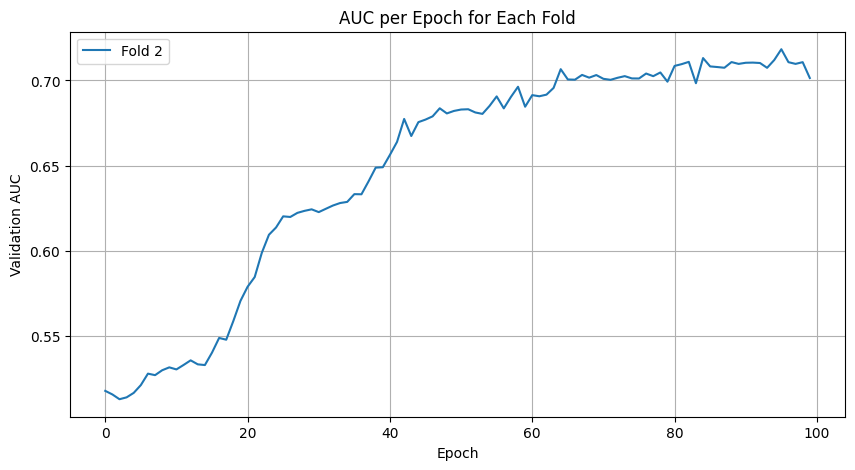

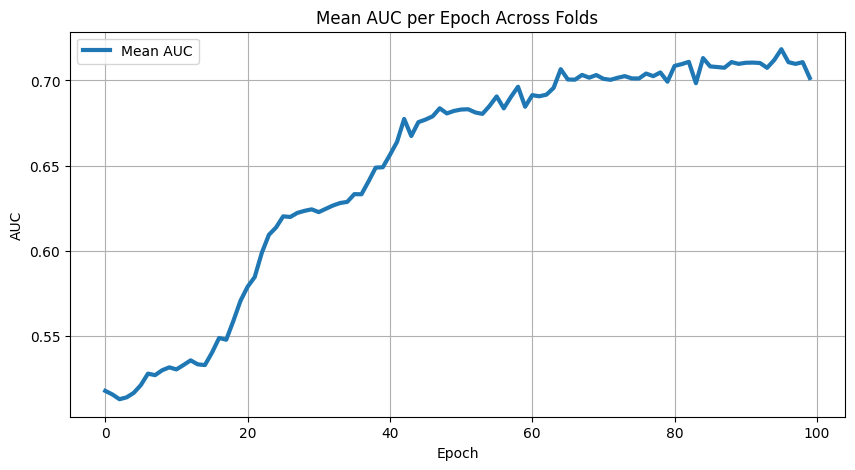

In [18]:
import matplotlib.pyplot as plt

# Vẽ từng fold
plt.figure(figsize=(10, 5))
for fold, auc_list in all_folds_auc.items():
    plt.plot(auc_list, label=f'Fold {fold}')

plt.xlabel('Epoch')
plt.ylabel('Validation AUC')
plt.title('AUC per Epoch for Each Fold')
plt.legend()
plt.grid(True)
plt.show()

# Vẽ AUC trung bình theo epoch (nếu tất cả folds có cùng số epoch)
max_epochs = max(len(v) for v in all_folds_auc.values())
mean_auc = []

for i in range(max_epochs):
    vals = []
    for auc_list in all_folds_auc.values():
        if i < len(auc_list):
            vals.append(auc_list[i])
    mean_auc.append(np.mean(vals))

plt.figure(figsize=(10, 5))
plt.plot(mean_auc, label='Mean AUC', linewidth=3)
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Mean AUC per Epoch Across Folds')
plt.grid(True)
plt.legend()
plt.show()